#### Intro

This is a starter notebook showcasing capabilities. 

Fit BOPDMD to SIC data.

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* select geographic areas by mask to see local evolution of ice - penguins??

In [1]:
%load_ext autoreload
%autoreload 2

import dill

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import torch 

import sys
import os
import pickle
import time

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

C:\Users\MITESH\AppData\Local\Temp\ipykernel_7968\3785193228.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#### Configs

In [2]:
# to run low res version of SIC images, can choose by how much to reduce the image size by adjusting step_thin, default = 3
run_lowres = False
step_thin = 3

# point in time: training set is before this point and test set is after this point
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 20 # window-averaging, thesis experiment uses [5,10,20]
num_year_data = 7 # number of years worth of data, thesis experiment with [2,5,7,10] years worth of history
T_train = 365 * num_year_data  # how many days worth of data needed
T_test = 365 * 2

#DMD rank
rank = 5

if run_lowres:
    img_type = 'lowres'
else:
    img_type = "highres"

#### Data Import


In [3]:
DATA, mask, x,y,Y_mean_month, Y_mean_week = get_ice_data(return_all = True)
del Y_mean_month, Y_mean_week

In [4]:
contour_compare(DATA[0], DATA[1])

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=364), IntSlider(value=157, description='f…

Thin spatial mesh: For prototyping

In [5]:
if run_lowres:
    DATA, mask = thin_data(DATA, mask, step_thin)
    x = x[::step_thin]
    y = y[::step_thin]

nx = len(x)
ny = len(y)

DATA[0].shape

(365, 314, 314)

##### Train DMD without UQ

##### Choose interval and train

In [6]:
# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)

X0_ = get_days_before(DATA, year, day, T_train+window-1) # get days from DATA
X1_ = get_days_after(DATA, year, day,T_test)

if window > 1:
    X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
    X1_ = get_test_set(DATA, year, day, window, T_test)

X0_.shape, X1_.shape

((2555, 314, 314), (730, 314, 314))

prepare data

In [7]:
t_train = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0_, 
                                                    t_train, 
                                                    time_delay = 2, 
                                                    mask = mask,
                                                    isKeepFirstTimes = True)

X_delayed.shape, t_delayed.shape, data_shape

#land mass is removed and then the two images are stacked to introduce non-stationarity 

((152098, 2554), (2554,), (2555, 314, 314))

train dmd

In [8]:
# # train dmd
# Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank = rank, 
#                              eig_constraints={
#                                 "stable", # choose Re(lambda)<0
#                                 "conjugate_pairs", # force complex conjugate pairs
#                                 } 
# )
# # reshape Psi to non-time-lagged spacial domain
# Psi = reshape_Psi2data(Psi_, data_shape, mask = mask) # reshape to non-time-delayed shape

In [9]:
# nonzero = []
# # A = X0_[:,0,0].reshape(X0.shape[0],1)
# for i in range(X_delayed.shape[0]):
#         if np.sum(X_delayed[i, :]) != 0:
#             nonzero.append(X_delayed[i, :])

# X_delayed_nonzero = np.array(nonzero)

In [10]:
# # train dmd
# Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank = rank, 
#                              eig_constraints={
#                                 "stable", # choose Re(lambda)<0
#                                 "conjugate_pairs", # force complex conjugate pairs
#                                 } 
# )
# # reshape Psi to non-time-lagged spacial domain
# Psi = reshape_Psi2data(Psi_, data_shape, mask = mask) # reshape to non-time-delayed shape

# X_pred_test = eval_dmd(Lambda, Psi_.T, bn, range(729))

In [11]:
dmd_avg_stats = []
dmd_MSE =[]
dmd_IIEE = []
dmd_MAE = []

pred_len = 180

t_all = np.arange(-T_train, T_test)

svd_ranks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for i in svd_ranks:
    Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank = i, 
                                eig_constraints={
                                    "stable", # choose Re(lambda)<0
                                    "conjugate_pairs", # force complex conjugate pairs
                                    } 
    )
    # reshape Psi to non-time-lagged spacial domain
    Psi = reshape_Psi2data(Psi_, data_shape, mask = mask) # reshape to non-time-delayed shape

    X_pred_test = eval_dmd(Lambda, Psi, bn, t_all)

    x_pred_testset = X_pred_test[T_train:,:,:]

    mse_per_img = ((x_pred_testset - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

    mae_per_img = (np.abs(x_pred_testset - X1_)).sum(axis=(1,2))/(X1_.shape[2]**2)

    iiee_pred = batched_iiee(torch.Tensor(x_pred_testset), torch.Tensor(X1_))

    total_iiee = iiee_calc(torch.Tensor(x_pred_testset[:pred_len]), torch.Tensor(X1_[:pred_len]))#,c_e = 0.0)

    avg_mse = mse_per_img[:pred_len].sum()/pred_len
    avg_iiee = iiee_pred[:pred_len].sum()/pred_len
    avg_mae = mae_per_img[:pred_len].sum()/pred_len

    # avg_mse_top = mse_per_img[:300].sum()/300
    dmd_avg_stats.append([int(i), avg_mse, avg_iiee.numpy().item(0), avg_mae])

    dmd_MSE.append(mse_per_img[:pred_len])
    dmd_MAE.append(mae_per_img[:pred_len])

    dmd_IIEE.append(iiee_pred[:pred_len].numpy())

    #print("test set mse for bopdmd: {}".format(avg_mse))
    
    print("SVD Rank: {} Test set MSE for BOPDMD 180 fwd: {:3f}  Test set IIEE for BOPDMD 180 fwd: {:3f}, Test set MAE for BOPDMD 180 fwd: {:3f}".format(i,avg_mse, avg_iiee, avg_mae))


    #filename = window, num_year_data, run_lowres, 

#C:\Project\0UCL_MSC_Project\outputs\pkl\pkl_bopdmd
## need to run 2,5,7,10 year history

## along with moving avg of 1,5,10,20
    #del 
    # plt.plot(mse_per_img)
    # plt.show()

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 3619453.217650699. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\pydmd\bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


SVD Rank: 2 Test set MSE for BOPDMD 180 fwd: 0.042398  Test set IIEE for BOPDMD 180 fwd: 15593.477539, Test set MAE for BOPDMD 180 fwd: 0.098201
SVD Rank: 3 Test set MSE for BOPDMD 180 fwd: 0.012580  Test set IIEE for BOPDMD 180 fwd: 4850.033203, Test set MAE for BOPDMD 180 fwd: 0.042467
SVD Rank: 4 Test set MSE for BOPDMD 180 fwd: 0.040840  Test set IIEE for BOPDMD 180 fwd: 11146.933594, Test set MAE for BOPDMD 180 fwd: 0.090088
SVD Rank: 5 Test set MSE for BOPDMD 180 fwd: 0.013655  Test set IIEE for BOPDMD 180 fwd: 5138.049805, Test set MAE for BOPDMD 180 fwd: 0.044164
SVD Rank: 6 Test set MSE for BOPDMD 180 fwd: 0.015652  Test set IIEE for BOPDMD 180 fwd: 4448.388672, Test set MAE for BOPDMD 180 fwd: 0.047158
SVD Rank: 7 Test set MSE for BOPDMD 180 fwd: 0.015021  Test set IIEE for BOPDMD 180 fwd: 5766.049805, Test set MAE for BOPDMD 180 fwd: 0.047337
SVD Rank: 8 Test set MSE for BOPDMD 180 fwd: 0.010812  Test set IIEE for BOPDMD 180 fwd: 4429.938965, Test set MAE for BOPDMD 180 fwd:

In [12]:
dmd_avg_stats_np = np.array(dmd_avg_stats)

dmd_avg_stats_df = pd.DataFrame(dmd_avg_stats_np)

dmd_MSE_np = np.array(dmd_MSE)
dmd_MAE_np = np.array(dmd_MAE)
dmd_IIEE_np = np.array(dmd_IIEE)

print(dmd_MSE_np,dmd_MAE_np ,dmd_IIEE_np)

column_indices = [0,1,2,3]
new_names = ['SVD rank','MSE','IIEE', 'MAE']
old_names = dmd_avg_stats_df.columns[column_indices]
dmd_avg_stats_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

dmd_avg_stats_df = dmd_avg_stats_df.astype({"SVD rank": int})

min_mse = dmd_avg_stats_df[dmd_avg_stats_df["MSE"] == dmd_avg_stats_df["MSE"].min()]
min_mae = dmd_avg_stats_df[dmd_avg_stats_df["MAE"] == dmd_avg_stats_df["MAE"].min()]
min_iiee = dmd_avg_stats_df[dmd_avg_stats_df["IIEE"] == dmd_avg_stats_df["IIEE"].min()]

dmd_MSE_df =  pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_MSE_np)), axis = 1, join= 'inner')
dmd_MAE_df =  pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_MAE_np)), axis = 1, join= 'inner')
dmd_IIEE_df = pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_IIEE_np)), axis = 1, join= 'inner')


print(dmd_avg_stats_df)

[[0.02593853 0.02734285 0.02879523 ... 0.01962647 0.01981913 0.01996191]
 [0.01535089 0.01524673 0.0151578  ... 0.01260543 0.01236551 0.01206468]
 [0.03993194 0.03836228 0.03688708 ... 0.09427516 0.09566195 0.09699166]
 ...
 [0.01296959 0.01335868 0.01373928 ... 0.02000365 0.01968567 0.01930169]
 [0.02139484 0.02238577 0.0233847  ... 0.01251554 0.01281028 0.01303516]
 [0.03359612 0.03429517 0.03495001 ... 0.05337117 0.05357866 0.05358694]] [[0.07697223 0.079305   0.08160171 ... 0.07048639 0.07073116 0.0708985 ]
 [0.05969393 0.05940858 0.05915897 ... 0.05314398 0.05255763 0.05185603]
 [0.07560222 0.07287106 0.07026539 ... 0.15021792 0.15144798 0.15261119]
 ...
 [0.05104025 0.05163331 0.05216239 ... 0.05982275 0.05934391 0.05878386]
 [0.06568793 0.06721263 0.06868392 ... 0.04515178 0.04579087 0.04628469]
 [0.08528985 0.08638526 0.08742538 ... 0.10444302 0.10505787 0.10542445]] [[11533 11989 12428 ...  4343  4191  4071]
 [10916 11169 11388 ...  3191  3150  3164]
 [ 9068  8580  8120 ...  4

In [13]:
with open(r'../outputs/pkl/pkl_bopdmd/bopdmd_sic_window_' + str(window)+'_numyears_'+ str(num_year_data) +'_' + str(img_type) + '_' + time.strftime("%Y%m%d"), 'wb') as output:
     pickle.dump([dmd_avg_stats_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df], output)

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']


<Axes: title={'center': 'MAE'}, xlabel='SVD rank', ylabel='MAE'>

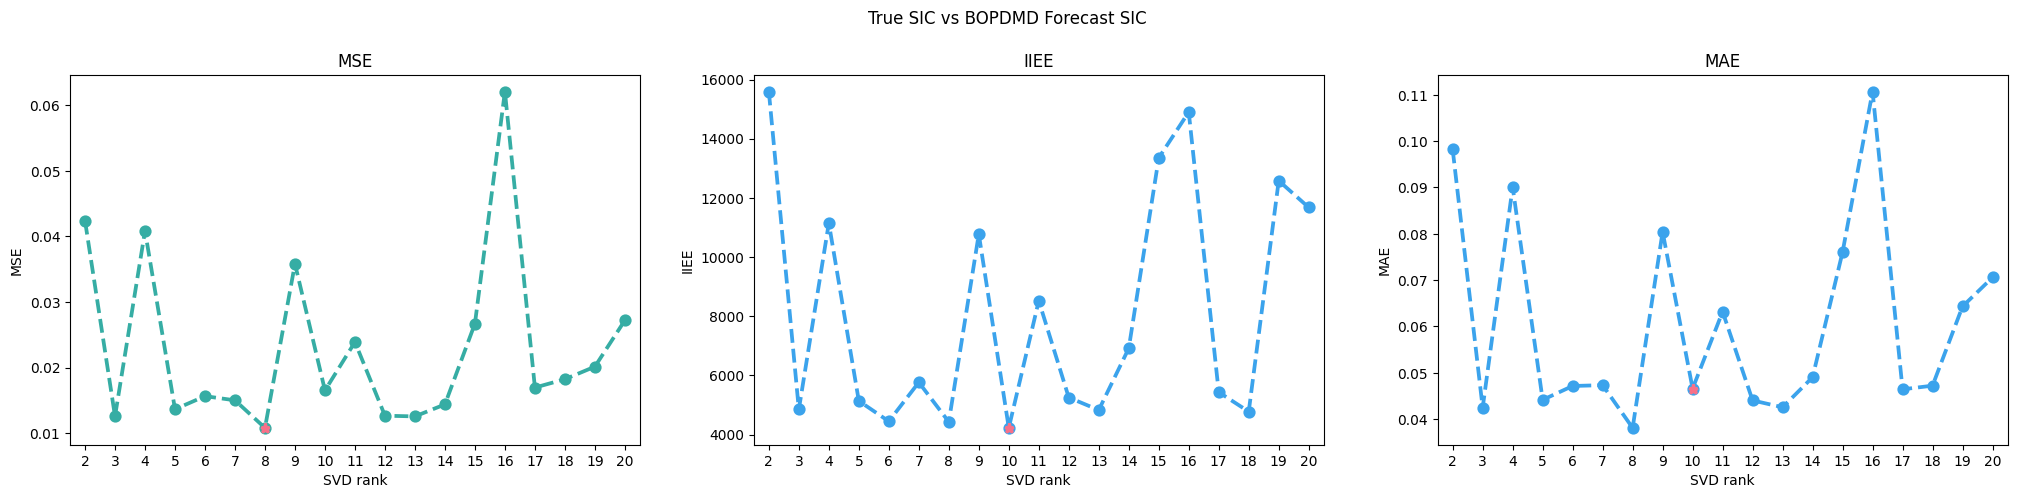

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(25, 5))

pal = sns.color_palette("husl")
print(pal.as_hex())

fig.suptitle("True SIC vs BOPDMD Forecast SIC")
fig.subplots_adjust(top=0.85)
sns.set_palette("husl",8)

sns.pointplot(data = dmd_avg_stats_df,x='SVD rank', y='MSE', ax = axs[0],linestyles='--',color= '#36ada4').set_title("MSE")
sns.pointplot(data = dmd_avg_stats_df,x='SVD rank', y='IIEE', ax = axs[1], linestyles='--', color= '#3ba3ec').set_title("IIEE")
sns.pointplot(data = dmd_avg_stats_df,x='SVD rank', y='MAE', ax = axs[2], linestyles='--', color= '#3ba3ec').set_title("MAE")
#
#axs[0].plot(min_mse["SVD_rank"], min_mse["MSE"], marker="*", color="r", markersize=10)

sns.pointplot(data = min_mse,x='SVD rank', y='MSE', ax = axs[0], markers= '*', color= '#f77189')
sns.pointplot(data = min_iiee,x='SVD rank', y='IIEE', ax = axs[1], markers= '*', color= '#f77189')
sns.pointplot(data = min_iiee,x='SVD rank', y='MAE', ax = axs[2], markers= '*', color= '#f77189')


#plt.show()

explore trained via integration

In [15]:
# t_all = np.arange(-T_train, T_train)
# true_after = get_test_set(DATA, year, day, window, T_train)
# X_true = np.concatenate((X0_, true_after), axis = 0)

# X_pred = eval_dmd(Lambda, Psi, bn, t_all)
# # COMPUTE METRIC OF PREDICTION
# Integral_pred = np.trapz(np.trapz(X_pred, x, axis = 2), y, axis = 1)
# Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

# plt.plot(t_all, Integral_pred.T, color = 'grey');
# plt.plot(t_all, Integral_true, label = 'true total ice', color = 'r')

# plt.axvline(0, linestyle = '--', color = 'k')

# plt.ylabel('total ice')
# plt.xlabel('days')

# plt.legend(loc = 'upper right')
# # plt.xlim([-120, 10])

In [16]:
# mse_perimage_chck = ((dec_test_arr - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

# mse_avg_chk = mse_perimage_chck.sum()/X1_.shape[0]
# mse_avg_chk

# plt.plot(mse_perimage_chck)
# plt.show()

# iiee_chck = batched_iiee(torch.Tensor(dec_test_arr), torch.Tensor(X1_))

# plt.plot(iiee_chck)
# plt.show()

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


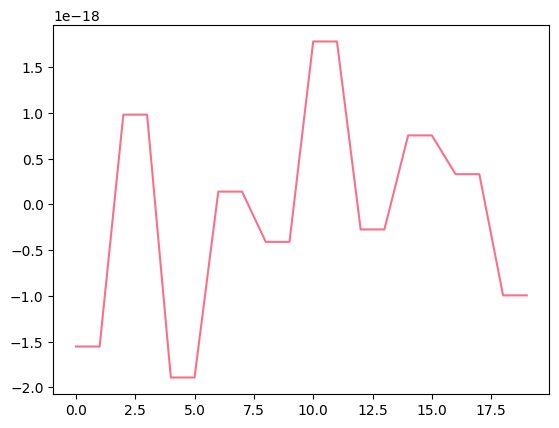

In [17]:
plt.plot(Psi_[1000,:])
plt.show()

In [18]:
contour_data(Psi.imag)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=19), IntSlider(value=157, description='f_…

In [19]:
contour_data(Psi.real)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=19), IntSlider(value=157, description='f_…

In [20]:
contour_compare(X_true, X_pred)

NameError: name 'X_true' is not defined

In [ ]:
#plt.plot(DATA[0][0],)
plt.contourf(DATA[30][350], cmap=plt.get_cmap('Blues_r'))
plt.show()